In [1]:
import pathlib

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

import data
import utils
import losses

## Load

In [2]:
met = data.MET_Data("../data/raw/MET_full_data.npz")
forms = {"T": "logcpm", "E": "pca-ipfx", "M": "arbors"}

In [3]:
experiments = {
    "mid": {
        "dir": "variational",
        "exps": ["t_arm", "e_arm", "m_arm", "t_e_arms", "t_m_arms", "e_m_arms", "met"]},
    "loose": {
        "dir": "variational_loose",
        "exps": ["t_e_arms", "t_m_arms", "e_m_arms", "met", "met_2d"]},
    "tight": {
        "dir": "variational_tight",
        "exps": ["t_e_arms", "t_m_arms", "e_m_arms", "met", "met_2d"]},
    "latent": {
        "dir": "latent_trials",
        "exps": ["met_2", "met_3", "met_4", "met_5", "met_7", "met_9", "met_10", "met_11", "met_12", "met_13", "met_15"]},
    "latentEM": {
        "dir": "latent_trials_EM",
        "exps": ["met_3", "met_4", "met_6", "met_8", "met_10", "met_12", "met_14", "met_16"]},
    "latentSmart": {
        "dir": "latent_trials_smart",
        "exps": ["met_4", "met_6", "met_8", "met_10", "met_12", "met_14", "met_16"]} 
}
experiment_paths = {exp_type: [pathlib.Path(f"../data/{info['dir']}/{exp_name}") for exp_name in info["exps"]]
                    for (exp_type, info) in experiments.items()}
experiment_dicts = {f"{path.stem}-{exp_type}": utils.load_jit_folds(path, get_checkpoints = False, check_step = 3) 
                    for (exp_type, exp_paths) in experiment_paths.items() for path in exp_paths}

In [4]:
infer = False
(best_results, checkpoint_results) = ({}, {})
for (exp_name, exp_dict) in experiment_dicts.items():
    modalities = exp_dict["config"]["modalities"]
    checkpoint_results[exp_name] = {}
    best_results[exp_name] = {}
    for (i, fold) in enumerate(exp_dict["folds"].values(), 1):
        test_data = met.query(fold["test_ids"], formats = [tuple(forms.values())], platforms = ["patchseq"])
        for in_modal in modalities:
            print(f"Generating {exp_name} - {i}: {in_modal} ->             ", end = "\r")
            in_form = forms[in_modal]
            x_forms = {in_form: torch.from_numpy(test_data[in_form]).float()}
            best_outputs = fold["best"].infer(x_forms, in_modal, modalities, sample = infer)
            for out_modal in modalities:
                modal_best = best_results[exp_name].setdefault(in_modal, {}).setdefault(out_modal, {})
                out_form = forms[out_modal]
                (latent, recon, mean, transf, out_mean, out_transf, _) = best_outputs[out_modal]
                final_mean = mean if out_mean is None else out_mean
                final_transf = transf if out_transf is None else out_transf
                modal_best = best_results[exp_name].setdefault(in_modal, {}).setdefault(out_modal, {})
                modal_best.setdefault("specimen_id", []).append(test_data["specimen_id"])
                modal_best.setdefault("means", []).append(final_mean.detach().numpy())
                modal_best.setdefault("transforms", []).append(final_transf.detach().numpy().astype("float64"))
                modal_best.setdefault("z_samples", []).append(latent.detach().numpy())
                modal_best.setdefault("recons", []).append(recon[out_form].detach().numpy())

            for (epoch, model) in fold.get("checkpoints", {}).items():
                outputs = model.infer(x_forms, in_modal, modalities, sample = infer)
                for out_modal in modalities:
                    modal_checkpoint = checkpoint_results[exp_name].setdefault(in_modal, {}).setdefault(out_modal, {})
                    epoch_outputs = modal_checkpoint.setdefault(epoch, {})
                    out_form = forms[out_modal]
                    (latent, recon, mean, transf, out_mean, out_transf, _) = outputs[out_modal]
                    final_mean = mean if out_mean is None else out_mean
                    final_transf = transf if out_transf is None else out_transf
                    epoch_outputs.setdefault("specimen_id", []).append(test_data["specimen_id"])
                    epoch_outputs.setdefault("means", []).append(final_mean.detach().numpy())
                    epoch_outputs.setdefault("transforms", []).append(final_transf.detach().numpy().astype("float64"))
                    epoch_outputs.setdefault("z_samples", []).append(latent.detach().numpy())
                    epoch_outputs.setdefault("recons", []).append(recon[out_form].detach().numpy())
print("Complete                                                 ")

Complete                                                 


## Reconstruction Performance

### Setup

In [5]:
specimen_ids = met.query(formats = [("logcpm",)], platforms = ["patchseq"])["specimen_id"]
loss_config = {"formats": {modal: [form] for (modal, form) in forms.items()}, "transform": {}, "device": "cpu"}
modal_losses = {"T": losses.FeatureR2(loss_config, met, specimen_ids), "E": losses.FeatureR2(loss_config, met, specimen_ids),
                "M": losses.SampleR2(loss_config, met, specimen_ids)}

In [11]:
latent_plot_data = {"Dataset": [], "Latent Dim": [], "Fold": [], "Input Modal": [], "Output Modal": [], "R2": []}
for (exp_name, exp_dict) in best_results.items():
    if "-latent" in exp_name:
        for (in_modal, out_dict) in exp_dict.items():
            for (out_modal, outputs) in out_dict.items():
                loss = modal_losses[out_modal]
                for (fold, (specimen_id, recons)) in enumerate(zip(outputs["specimen_id"], outputs["recons"]), 1):
                    orig_data = met.get_specimens(specimen_id)[forms[out_modal]]
                    r2 = 1 - loss(torch.from_numpy(orig_data), torch.from_numpy(recons), forms[out_modal]).item()
                    dataset = "Patch+EM" if "EM" in exp_name else "Patch+Smart" if "Smart" in exp_name else "Patch"
                    latent_plot_data["Dataset"].append(dataset)
                    latent_plot_data["Latent Dim"].append(int(exp_name.split("_")[-1].split("-")[0]))
                    latent_plot_data["Fold"].append(fold)
                    latent_plot_data["Input Modal"].append(in_modal)
                    latent_plot_data["Output Modal"].append(out_modal)
                    latent_plot_data["R2"].append(r2)
latent_plot_data = pd.DataFrame(latent_plot_data)

### R2 Plots

### Latent Dimension

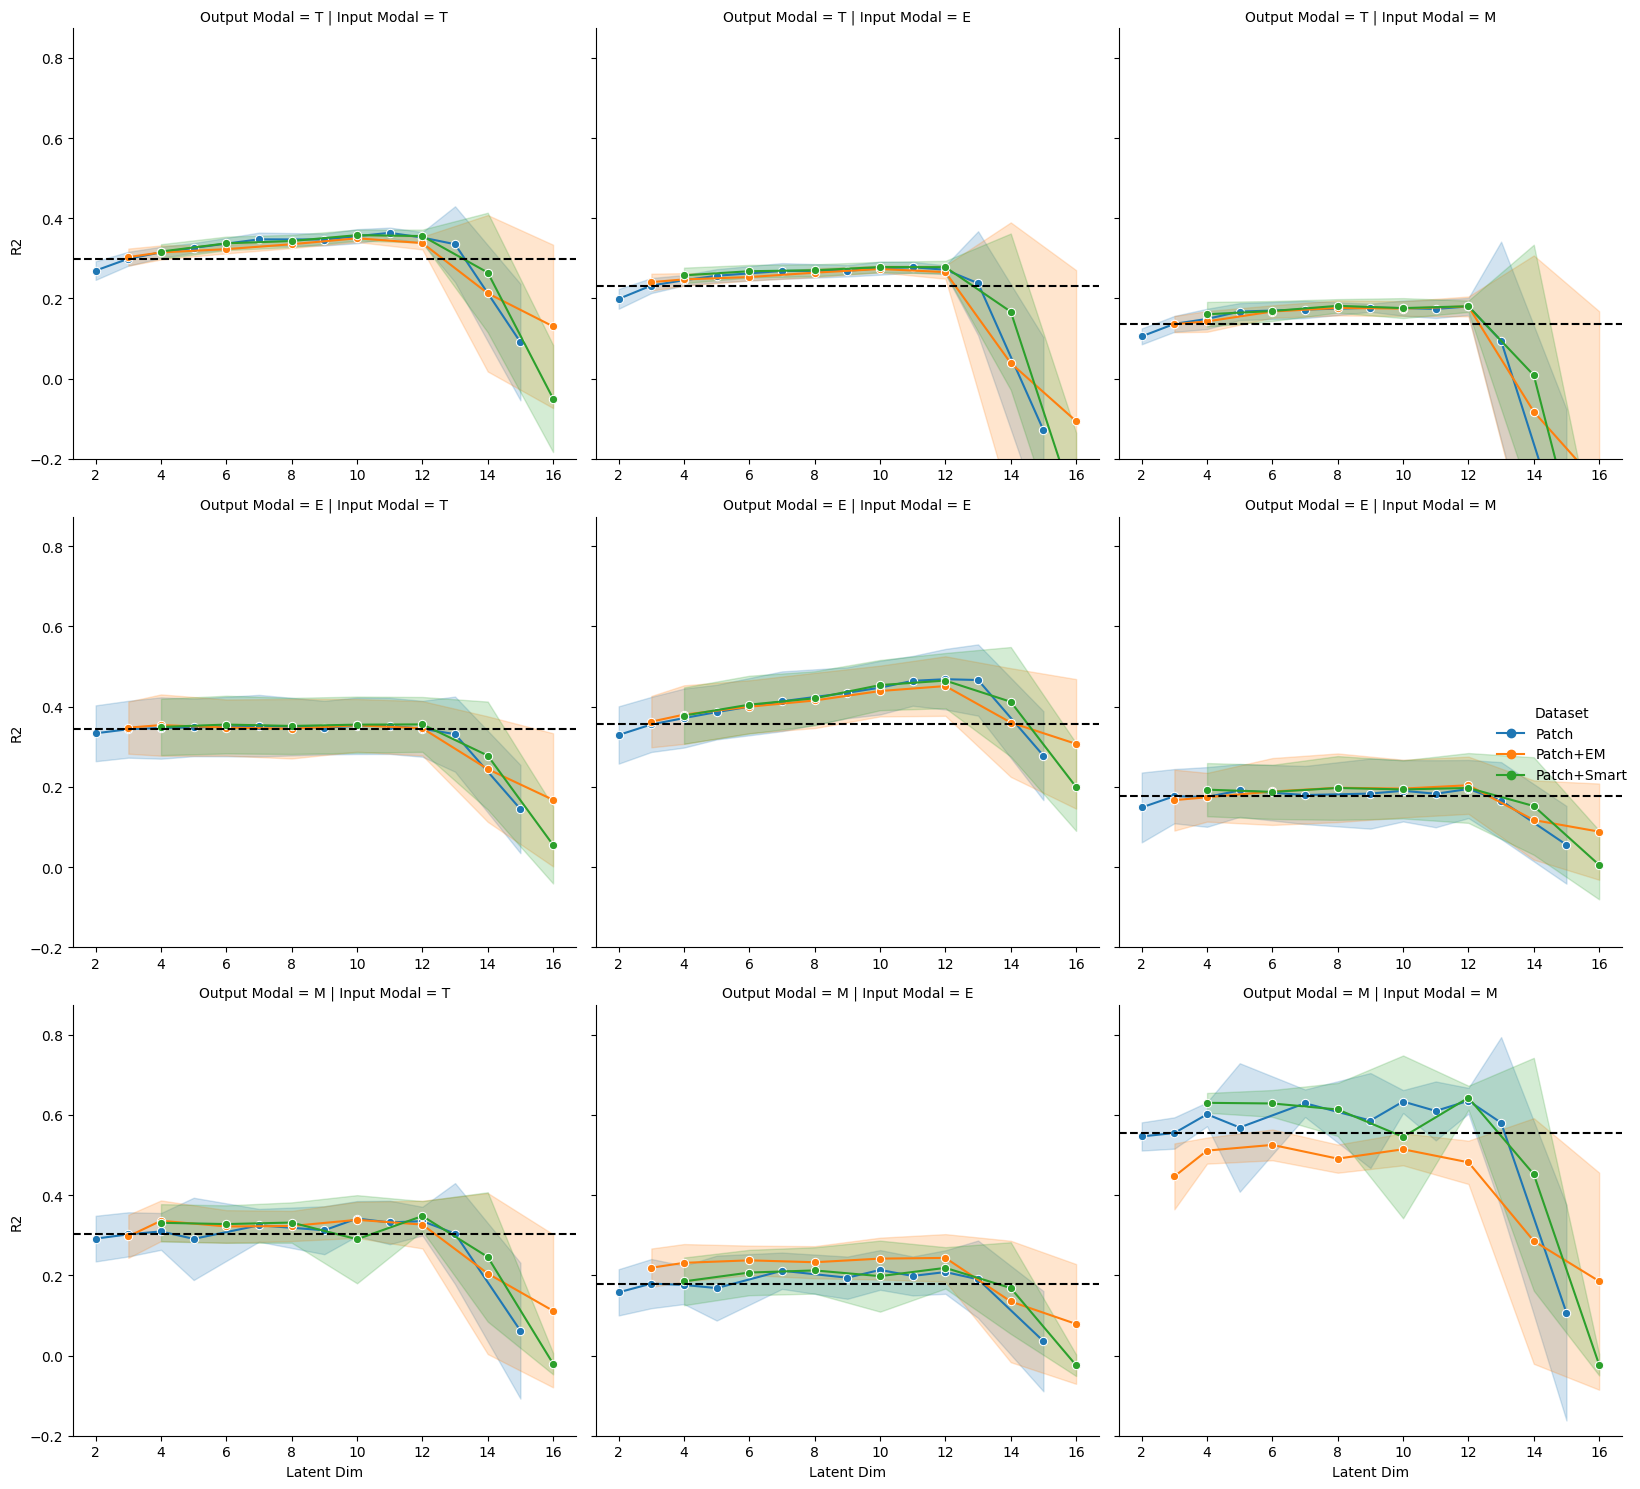

In [53]:
refs = latent_plot_data[latent_plot_data["Latent Dim"] == 3].groupby(["Dataset", "Input Modal", "Output Modal"]).mean()
plot = sns.relplot(data = latent_plot_data, x = "Latent Dim", y = "R2", row = "Output Modal", col = "Input Modal", hue = "Dataset",
                   kind = "line", marker = "o", errorbar = "sd")
plt.ylim(bottom = -0.2)
for (out_modal, ax_list) in zip(["T", "E", "M"], plot.axes):
    for (in_modal, ax) in zip(["T", "E", "M"], ax_list):
        ref_r2 = refs.query('`Dataset` == "Patch" & `Input Modal` == @in_modal & `Output Modal` == @out_modal')["R2"].item()
        ax.axhline(ref_r2, color = "black", ls = "--")
        ax.tick_params(labelbottom = True)
plt.tight_layout()
# plt.savefig("latent_dim_r2.pdf")
plt.show()

## Covariances of 2D Models

### Setup

In [13]:
modal_cov = {}
for (exp_name, exp_dict) in best_results.items():
    modal_cov[exp_name] = {}
    for (in_modal, out_dict) in exp_dict.items():
        for (out_modal, metrics) in out_dict.items():
            cov = [l @ l.transpose([0, 2, 1]) for l in metrics["transforms"]]
            modal_cov[exp_name].setdefault(in_modal, {})[out_modal] = cov

In [14]:
var_plot_data = {"Experiment": [], "Input Modal": [], "Output Modal": [], "Max Log-StDev": [], "Min Log-StDev": [], "Type": []}
ax_lims = {}
for (exp_name, exp_dict) in modal_cov.items():
    if exp_name in {"met_2d-tight", "met_2d-loose"}:
        for (in_modal, out_dict) in exp_dict.items():
            for (out_modal, covs) in out_dict.items():
                var_eigs = np.log(np.concatenate([np.linalg.eigvalsh(cov) for cov in covs]))
                var_plot_data["Experiment"] += [exp_name]*var_eigs.shape[0]
                var_plot_data["Input Modal"] += [in_modal]*var_eigs.shape[0]
                var_plot_data["Output Modal"] += [out_modal]*var_eigs.shape[0]
                var_plot_data["Type"] += ["Encoder" if in_modal == out_modal else "Cross-Map"]*var_eigs.shape[0]
                var_plot_data["Max Log-StDev"] += (0.5*var_eigs[:, -1]).tolist()
                var_plot_data["Min Log-StDev"] += (0.5*var_eigs[:, 0]).tolist()
                ax_lims.setdefault(in_modal, {})[out_modal] = (0.5*var_eigs.min() - 0.25, 0.5*var_eigs.max() + 0.25)

### Determinant Distributions

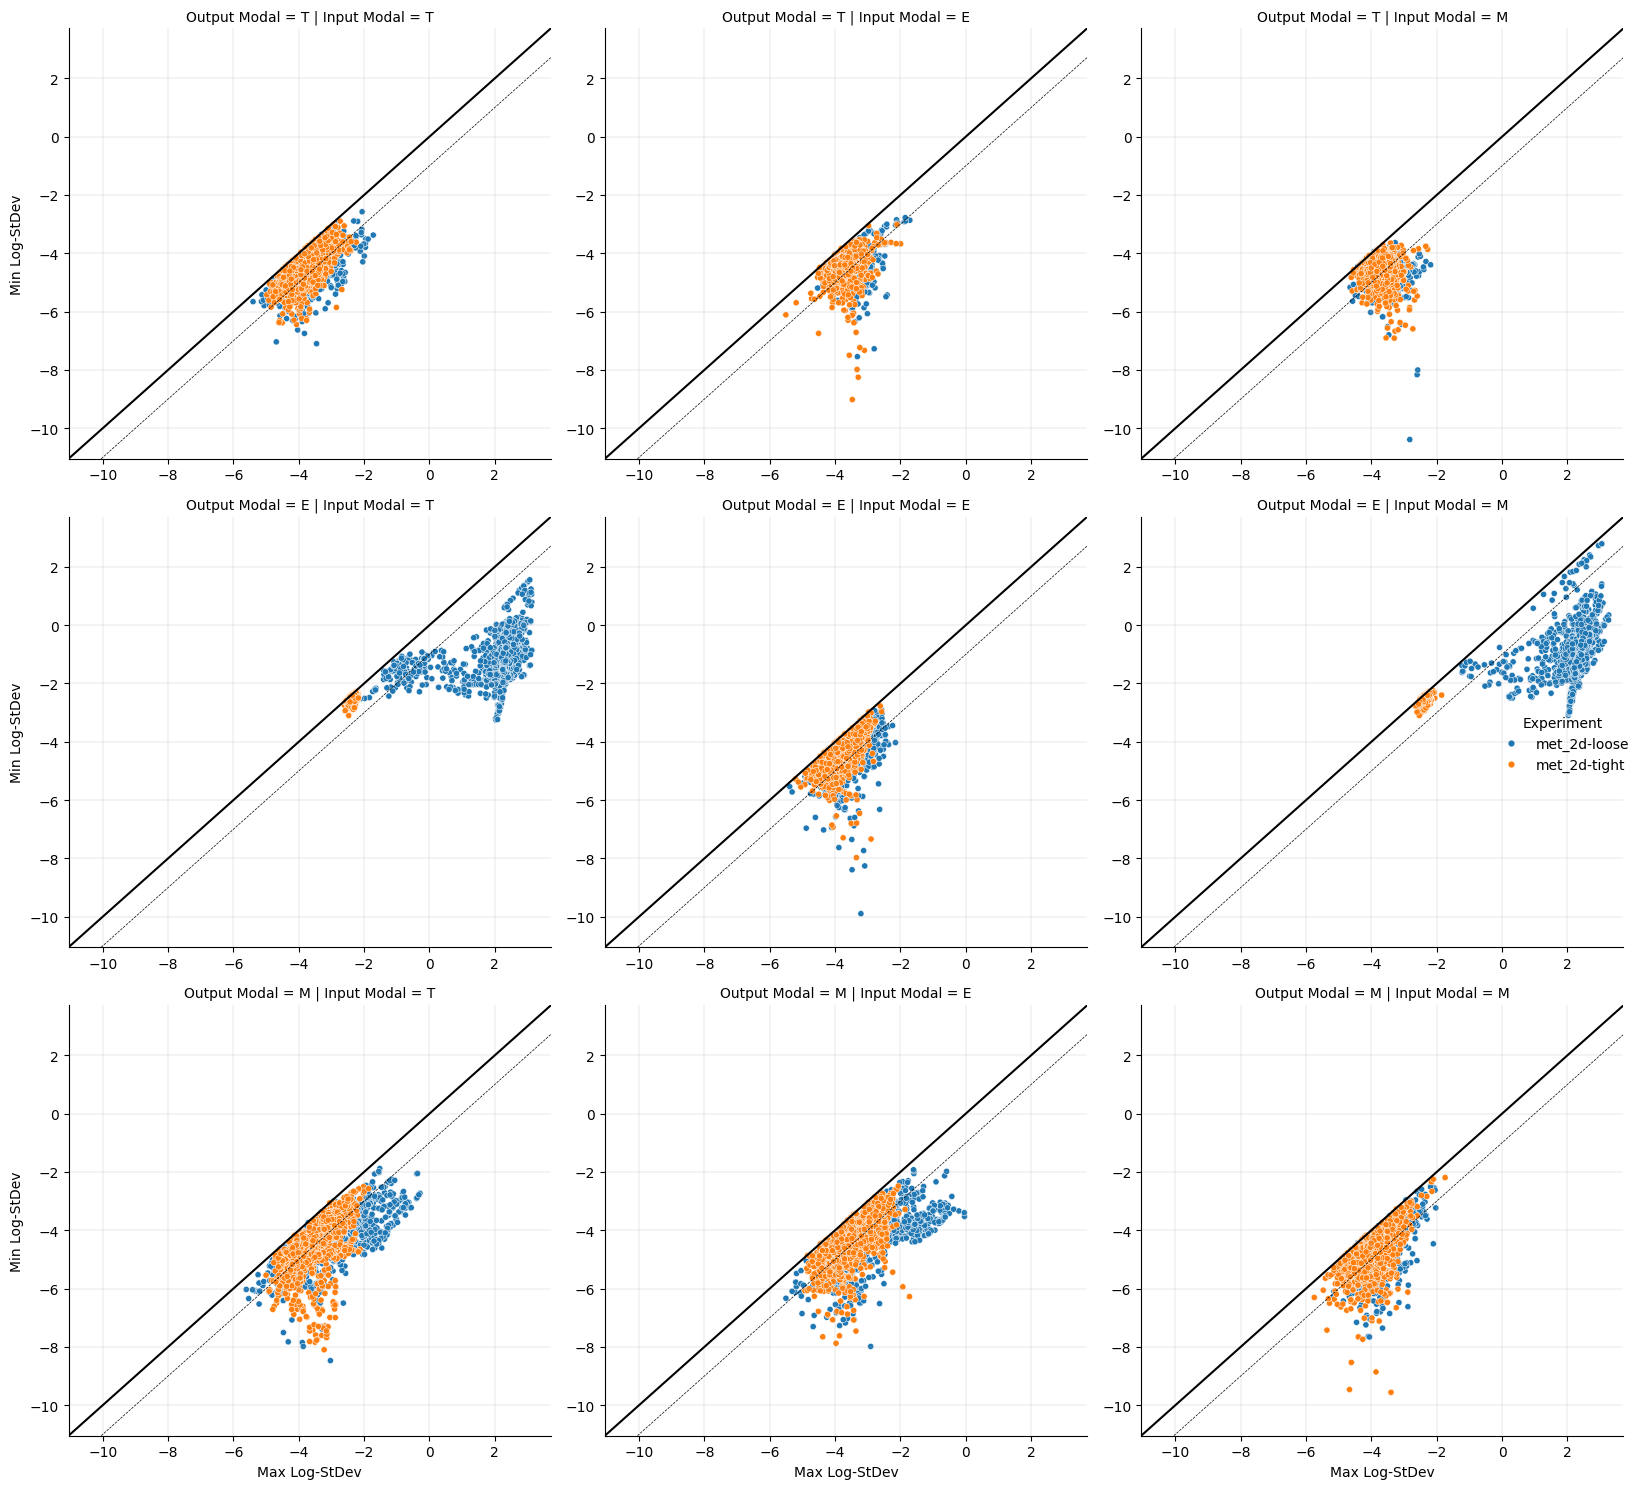

In [54]:
plot = sns.relplot(
    data = var_plot_data, x = "Max Log-StDev", y = "Min Log-StDev", row = "Output Modal", col = "Input Modal", hue = "Experiment",
    col_order = ["T", "E", "M"], row_order = ["T", "E", "M"], s = 20, facet_kws = {"sharex": True, "sharey": True})
ex_ax = plot.axes[0][0]
ax_lims = (min(ex_ax.get_xlim()[0], ex_ax.get_ylim()[0]), max(ex_ax.get_xlim()[1], ex_ax.get_ylim()[1]))
for (i, in_modal) in enumerate(["T", "E", "M"]):
    for (j, out_modal) in enumerate(["T", "E", "M"]):
        ax = plot.axes[j][i]
        (min_lim, max_lim) = ax_lims
        ax.set_xlim(min_lim, max_lim)
        ax.set_ylim(min_lim, max_lim)
        ax.plot([min_lim, max_lim], [min_lim, max_lim], color = "black")
        ax.plot([min_lim + 1, max_lim + 1], [min_lim, max_lim], color = "black", linestyle = "dashed", linewidth = 0.5)
        ax.grid(linewidth = 0.2)
        ax.tick_params(labelbottom = True, labelleft = True)
plt.tight_layout()
# plt.savefig("cov_eig_plots.pdf")
plt.show()

## 2D Latent Space Visualization

### Setup

#### Encoder Latent Space

In [44]:
all_means = []
modal_means = {}
for (in_modal, out_dict) in best_results["met_2d-tight"].items():
    for (out_modal, metrics) in out_dict.items():
        all_means.append(metrics["means"][0])
        modal_means.setdefault(in_modal, {})[out_modal] = metrics["means"][0]
pca = PCA(2).fit(np.concatenate(all_means))
proj_means = {in_modal: {out_modal: pca.transform(means) for (out_modal, means) in out_dict.items()}
              for (in_modal, out_dict) in modal_means.items()}
proj_cov = {in_modal: {out_modal: np.einsum("ij,njk,kl->nil", pca.components_, cov[0], pca.components_.T) 
                       for (out_modal, cov) in out_dict.items()} 
            for (in_modal, out_dict) in modal_cov["met_2d-tight"].items()}

In [45]:
p = np.stack(np.meshgrid(np.linspace(-5, 5, 501), np.linspace(-5, 5, 501)), -1)
log_density = {}
for (in_modal, out_dict) in proj_means.items():
    for (out_modal, proj_mean) in out_dict.items():
        cov = proj_cov[in_modal][out_modal]
        centered = p[:, :, None] - proj_mean[None, None]
        exp = -0.5*np.einsum("xyni,nij,xynj->xyn", centered, np.linalg.inv(cov), centered)
        norm = -np.log(2*np.pi) - 0.5*np.linalg.slogdet(cov)[1]
        log_density.setdefault(in_modal, {})[out_modal] = exp + norm[None, None]

In [46]:
mean_density = {}
for (in_modal, out_dict) in log_density.items():
    for (out_modal, density) in out_dict.items():
        max_density = density.max(-1)
        mean = max_density + np.log(1 + np.exp(density - max_density[..., None]).sum(-1)) - np.log(density.shape[-1])
        mean_density.setdefault(in_modal, {})[out_modal] = mean

#### Mapper Latent Space

In [48]:
all_means2 = []
modal_means2 = {}
for (in_modal, out_dict) in best_results["met_2d-tight"].items():
    for (out_modal, metrics) in out_dict.items():
        all_means2.append(metrics["means"][0])
        modal_means2.setdefault(in_modal, {})[out_modal] = metrics["means"][0]
proj_means2 = modal_means2

In [49]:
(height, width) = (5, 5)
p_gauss = np.stack(np.meshgrid(np.linspace(-2, 2, height), np.linspace(-2, 2, width)), -1)
meshes = {}
for (in_modal, out_dict) in modal_means2.items():
    for out_modal in out_dict:
        if in_modal != out_modal:
            mapper = experiment_dicts["met_2d-tight"]["folds"][1]["best"].mappers[f"{in_modal}-{out_modal}"]
            input_mesh = p_gauss.reshape(-1, 2)
            meshes.setdefault(in_modal, {})[out_modal] = mapper(torch.from_numpy(input_mesh).float())[1].reshape(height, width, 2, 2).numpy(force = True)

In [50]:
thresh = -2.5
p2 = np.stack(np.meshgrid(np.linspace(-3, 3, 501), np.linspace(-3, 3, 501)), -1)
mean_density2 = {}
for (in_modal, out_dict) in meshes.items():
    for (out_modal, cov) in out_dict.items():
        centered = p2[:, :, None, None] - p_gauss[None, None]
        exp = -0.5*np.einsum("xyabi,abij,xyabj->xyab", centered, np.linalg.inv(cov), centered)
        norm = -np.log(2*np.pi) - 0.5*np.linalg.slogdet(cov)[1]
        density = exp + norm[None, None]
        density[density < thresh] = -100000000
        max_density = density.max((-2, -1), keepdims = True)
        mean = max_density[..., 0, 0] + np.log(1 + np.exp(density - max_density).sum((-2, -1))) - np.log(np.prod(density.shape[-2:]))
        mean_density2.setdefault(in_modal, {})[out_modal] = mean

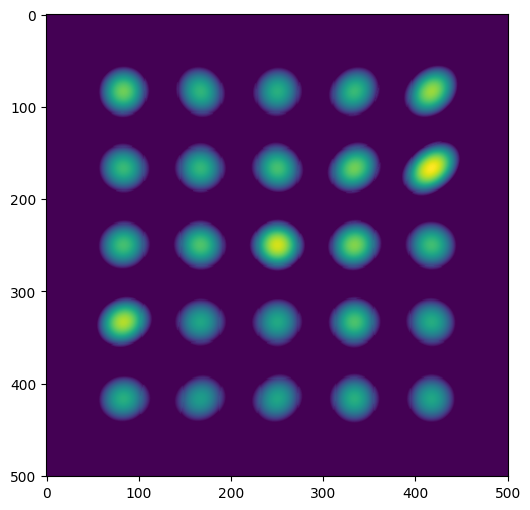

In [51]:
%matplotlib inline
fig = plt.figure(figsize = (15, 6))
density_axes = fig.subplots(1, 1)
filtered = mean_density2["T"]["E"].copy()
filtered[filtered < thresh] = thresh
density_axes.imshow(filtered, interpolation = None, aspect = "equal")
plt.show()

### Density Plot

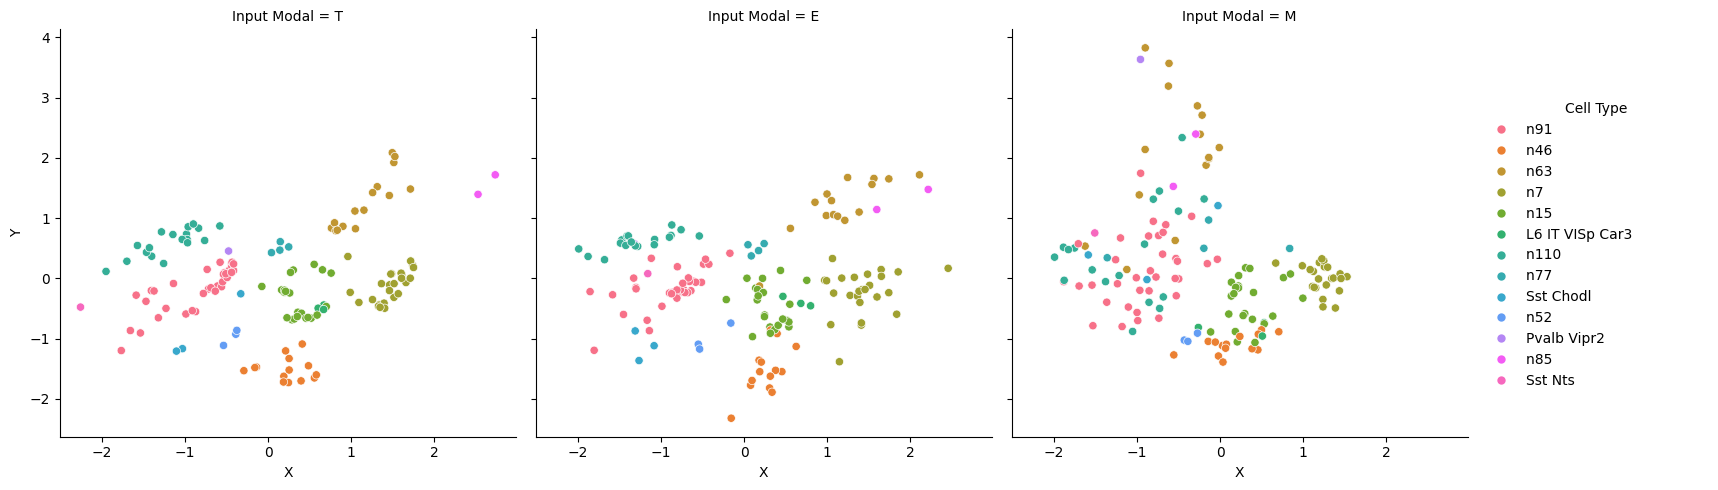

In [40]:
latent_mean_plot_data = {"Input Modal": [], "Output Modal": [], "X": [], "Y": [], "Cell Type": []}
for (in_modal, out_dict) in best_results["met_2d-tight"].items():
    for (out_modal, metrics) in out_dict.items():
        if in_modal == out_modal:
            means = proj_means[in_modal][out_modal]
            cell_types = met.get_specimens(metrics["specimen_id"][0])["merged_cluster_label_at80"]
            latent_mean_plot_data["Input Modal"].extend([in_modal]*cell_types.size)
            latent_mean_plot_data["Output Modal"].extend([out_modal]*cell_types.size)
            latent_mean_plot_data["X"].extend(means[:, 0].tolist())
            latent_mean_plot_data["Y"].extend(means[:, 1].tolist())
            latent_mean_plot_data["Cell Type"].extend(cell_types.tolist())
plot = sns.relplot(latent_mean_plot_data, x = "X", y = "Y", col = "Input Modal", hue = "Cell Type")
plt.show()

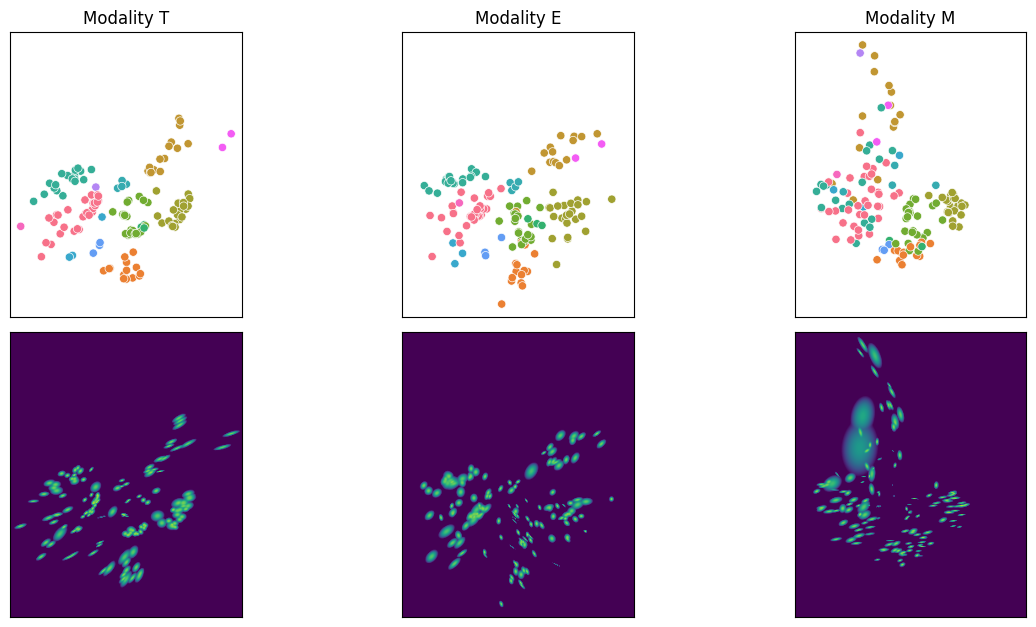

In [52]:
fig = plt.figure(figsize = (15, 6))
(mean_fig, density_fig) = fig.subfigures(2, 1)
mean_axes = mean_fig.subplots(1, 3, sharex = True, sharey = True)
density_axes = density_fig.subplots(1, 3)
modalities = ["T", "E", "M"]
for (i, modal) in enumerate(modalities):
    metrics = best_results["met_2d-tight"][modal][modal]
    latent_mean_plot_data = {"X": [], "Y": [], "Cell Type": []}
    means = proj_means[modal][modal]
    cell_types = met.get_specimens(metrics["specimen_id"][0])["merged_cluster_label_at80"]
    latent_mean_plot_data["X"].extend(means[:, 0].tolist())
    latent_mean_plot_data["Y"].extend(means[:, 1].tolist())
    latent_mean_plot_data["Cell Type"].extend(cell_types.tolist())
    sns.scatterplot(latent_mean_plot_data, x = "X", y = "Y", hue = "Cell Type", ax = mean_axes[i], legend = False)
    mean_axes[i].set_aspect("equal")
    mean_axes[i].get_xaxis().set_visible(False)
    mean_axes[i].get_yaxis().set_visible(False)
    mean_axes[i].set_title(f"Modality {modal}")

((x_min, x_max), (y_min, y_max)) = (mean_axes[0].get_xlim(), mean_axes[0].get_ylim())
(x_start, x_end) = (np.sum(p[::-1][:, 0, 1] < x_min), np.sum(p[::-1][0, :, 0] > x_max))
(y_start, y_end) = (np.sum(p[::-1][:, 0, 1] < y_min), np.sum(p[::-1][:, 0, 1] > y_max))
for (i, modal) in enumerate(modalities):
    filtered = mean_density[modal][modal].copy()[::-1]
    filtered[filtered < -10] = -10
    density_axes[i].imshow(filtered[y_end:-y_start, x_start:-x_end], interpolation = None, aspect = "equal")
    density_axes[i].get_xaxis().set_visible(False)
    density_axes[i].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Sanity Checks

In [21]:
met_model = experiment_dicts["met"]["folds"][1]["best"]
example = met.query(formats = [("logcpm",)])["logcpm"][:1]

### Sampling

In [22]:
(mean, transf) = met_model.T_enc({"logcpm": torch.as_tensor(example).float()})
(mean, transf) = met_model.mappers["T-E"](mean)

In [23]:
samples = met_model.z_sample(mean.expand(1000000, 3), transf.expand(1000000, 3, 3))

In [24]:
(mean, samples.mean(0))

(tensor([[-0.3444,  0.3936, -1.7431]], grad_fn=<DifferentiableGraphBackward>),
 tensor([-0.3444,  0.3933, -1.7436], grad_fn=<MeanBackward1>))

In [25]:
(torch.cov(samples.T), transf[0]@transf[0].T)

(tensor([[ 0.0862,  0.0385,  0.0748],
         [ 0.0385,  0.2084, -0.0153],
         [ 0.0748, -0.0153,  0.2934]], grad_fn=<SqueezeBackward0>),
 tensor([[ 0.0863,  0.0385,  0.0750],
         [ 0.0385,  0.2080, -0.0154],
         [ 0.0750, -0.0154,  0.2939]], grad_fn=<MmBackward0>))